# **Import, cleaning and preparation of CDSS data from Rwanda for spatio-temporal clustering**

Please note the usage of the following abbrevations:
- RW = Rw = Rwanda
- hf = healthcare facility
- ...

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install thefuzz
!{sys.executable} -m pip install pyshp

You should consider upgrading via the 'c:\Users\sidla\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\sidla\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\sidla\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


# Import data and get overview

In [4]:
# import raw data
raw_rw_data = pd.read_csv("data/rwanda/13-02-2023-export_flat/answers.csv", warn_bad_lines=True, error_bad_lines=False)
raw_rw_data

b'Skipping line 9087: expected 2025 fields, saw 2028\n'


,medical_case_id,medical_case_local_id,medical_case_consent,medical_case_isEligible,medical_case_redcap,medical_case_consultation_date,medical_case_closed_at,medical_case_force_close,medical_case_redcap_flag,medical_case_duplicate,...,DRUG - ampicillin im [for infants under 2 months old] (at-facility when referral is not feasible) - 5936,DRUG - gentamicin im [for infants under 2 months old](at-facility when referral not feasible) - 5393,DRUG - azithromycin po - 5871,DRUG - amoxicillin hd po (syrup) - 22761,DRUG - ampicillin + cloxacillin (ampiclox) po - 5325,DRUG - epinephrine (adrenaline) im - 5909,DRUG - dextrose iv bolus - 5942,DRUG - amoxicillin / clavulanic acid iv - 5920,DRUG - Antibiotic prescribed ?,custom_drugs
0,7,236b5efb-a55d-457b-838f-6aaf8cb8bc1c,1,NaN,1,2021-08-12 16:10:53,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,8,61e8ca0f-ae96-4bf4-a0d0-cdd010f0375a,1,NaN,1,2021-08-12 16:10:56,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,9,7ceb68de-1a3a-4f19-94b5-0f8c5b67bd05,1,NaN,1,2021-08-12 16:11:00,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,10,a473563c-9207-475c-aa16-a93dea8cb729,1,NaN,1,2021-08-12 16:11:04,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,11,bb129051-fc4c-4142-be6b-4b0258f65b93,1,NaN,1,2021-08-12 16:11:07,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87572,89937,1106a8e6-7ad5-4f11-867d-d5f8a6d73b39,1,NaN,1,2023-02-06 08:28:25,2023-02-06 20:30:30,1.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
87573,89938,334cb4eb-4040-4140-b605-b0efb4f5a45d,1,NaN,1,2023-02-06 08:31:02,2023-02-06 20:32:13,1.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
87574,89939,35c2a3d1-997d-4c9b-aee0-a413e0be8cb4,1,NaN,1,2023-02-07 10:21:58,2023-02-07 22:24:11,1.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
87575,89940,4e6dd03f-a5ed-4894-9cad-4fc126fcaa6a,1,NaN,1,2023-02-06 08:04:54,2023-02-06 20:06:28,1.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [5]:
# print column names an their data type
for col in raw_rw_data.columns:
    print("col:",col,"- dtype:",raw_rw_data.dtypes[col])

col: medical_case_id - dtype: int64
col: medical_case_local_id - dtype: object
col: medical_case_consent - dtype: int64
col: medical_case_isEligible - dtype: float64
col: medical_case_redcap - dtype: int64
col: medical_case_consultation_date - dtype: object
col: medical_case_closed_at - dtype: object
col: medical_case_force_close - dtype: float64
col: medical_case_redcap_flag - dtype: int64
col: medical_case_duplicate - dtype: int64
col: medical_case_is_drop - dtype: int64
col: medical_case_app_version - dtype: float64
col: patient_id - dtype: int64
col: patient_birthdate - dtype: int64
col: patient_gender - dtype: object
col: patient_local_patient_id - dtype: object
col: patient_consent - dtype: object
col: patient_redcap - dtype: int64
col: patient_duplicate - dtype: int64
col: patient_other_uid - dtype: object
col: patient_other_study_id - dtype: object
col: patient_other_group_id - dtype: float64
col: patient_merged_with - dtype: object
col: patient_is_drop - dtype: int64
col: pati

# Quality control: checking for anomalies in data

In [6]:
description_raw_rw_data = raw_rw_data.describe()
description_raw_rw_data 

,medical_case_id,medical_case_consent,medical_case_isEligible,medical_case_redcap,medical_case_force_close,medical_case_redcap_flag,medical_case_duplicate,medical_case_is_drop,medical_case_app_version,patient_id,...,DRUG - gentamicin im [for infants under 2 months old] [at-facility when referral not feasible - critical illness) - 5934,DRUG - ampicillin im [for infants under 2 months old] (at-facility when referral is not feasible) - 5936,DRUG - gentamicin im [for infants under 2 months old](at-facility when referral not feasible) - 5393,DRUG - azithromycin po - 5871,DRUG - amoxicillin hd po (syrup) - 22761,DRUG - ampicillin + cloxacillin (ampiclox) po - 5325,DRUG - epinephrine (adrenaline) im - 5909,DRUG - dextrose iv bolus - 5942,DRUG - amoxicillin / clavulanic acid iv - 5920,DRUG - Antibiotic prescribed ?
count,87577.000000,87577.000000,0.0,87577.000000,86668.000000,87577.0,87577.000000,87577.000000,0.0,87577.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87577.000000
mean,46015.872135,0.999954,NaN,0.999954,0.296015,0.0,0.006223,0.003334,NaN,30895.085947,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245384
std,25440.931820,0.006758,NaN,0.006758,0.456500,0.0,0.078641,0.057647,NaN,18030.192427,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.430317
min,7.000000,0.000000,NaN,0.000000,0.000000,0.0,0.000000,0.000000,NaN,6.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,24114.000000,1.000000,NaN,1.000000,0.000000,0.0,0.000000,0.000000,NaN,14983.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,46104.000000,1.000000,NaN,1.000000,0.000000,0.0,0.000000,0.000000,NaN,29911.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,68036.000000,1.000000,NaN,1.000000,1.000000,0.0,0.000000,0.000000,NaN,46193.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
max,89941.000000,1.000000,NaN,1.000000,1.000000,0.0,1.000000,1.000000,NaN,64783.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


## Low variance columns

<AxesSubplot:title={'center':'Low variance columns in rw data set'}>

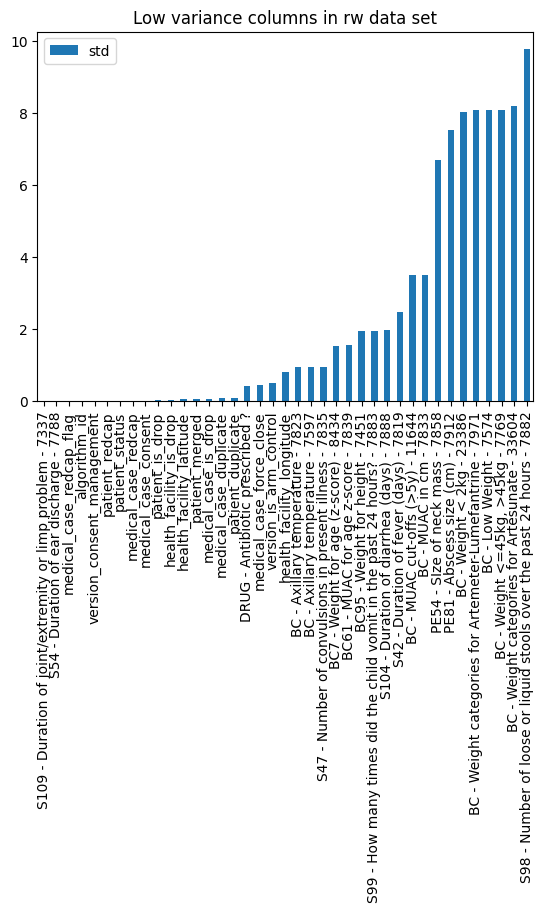

In [7]:
# check for low variance columns
low_var_threshold = 10 # TODO should be different for binary columns
var_rw_data = description_raw_rw_data.loc[["std"]].transpose().dropna().sort_values(by=["std"])

# plot low variance columns
var_rw_data[var_rw_data["std"] <= low_var_threshold].plot(kind="bar", rot=90, title="Low variance columns in rw data set")

## Missingness of columns

In [8]:
# number of nan per column
nnan_rw_data = raw_rw_data.isnull().sum(axis = 0).to_frame(name="nnan")


In [9]:
# columns with no nan
print(nnan_rw_data[nnan_rw_data["nnan"] == 0].size/nnan_rw_data.size*100, "%", "of columns contain no NaN values!")
nnan_rw_data[nnan_rw_data["nnan"] == 0]

2.4691358024691357 % of columns contain no NaN values!


,nnan
medical_case_id,0
medical_case_local_id,0
medical_case_consent,0
medical_case_redcap,0
medical_case_consultation_date,0
medical_case_redcap_flag,0
medical_case_duplicate,0
medical_case_is_drop,0
patient_id,0
patient_birthdate,0


96.44444444444444 % of columns contain more than 95 % of NaN values!


<AxesSubplot:title={'center':'Columns with more than 95% of NaN values'}>

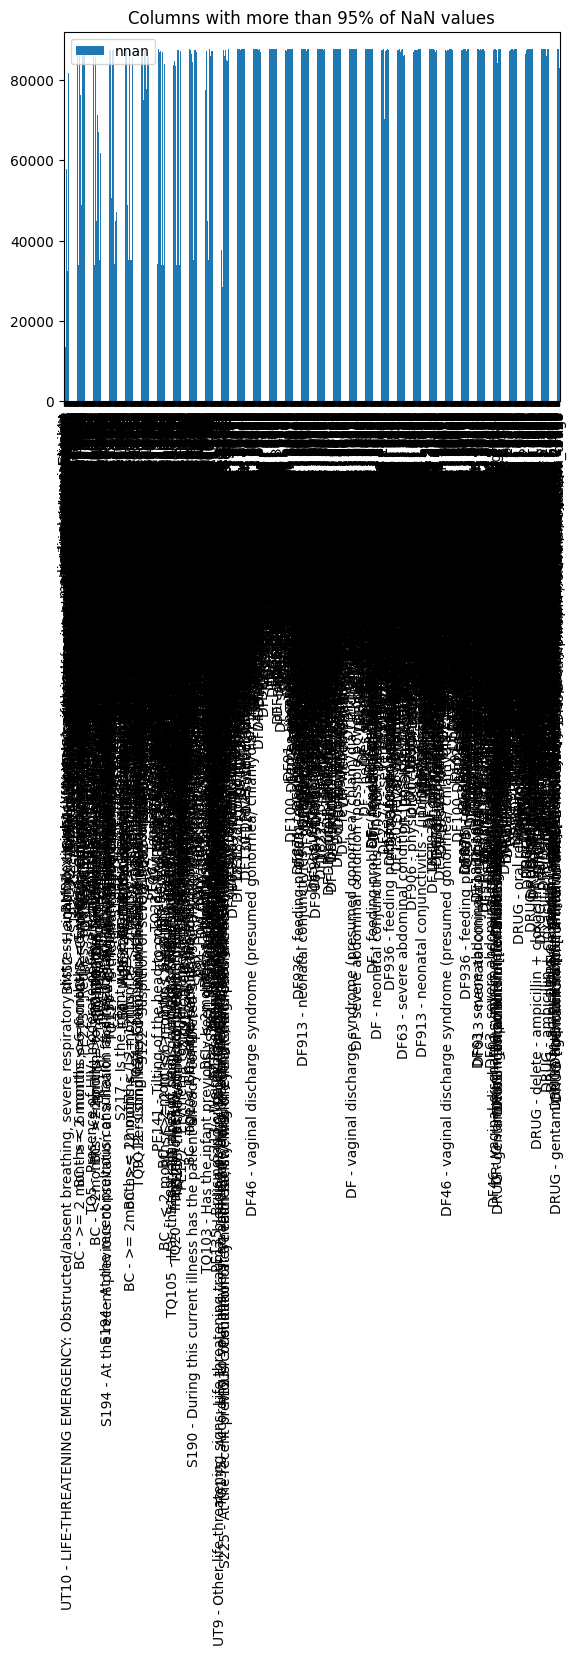

In [10]:
# plot columns with too many NaN values
nnan_threshold = 95 # in %
print(nnan_rw_data[nnan_rw_data["nnan"] / nnan_rw_data.size * 100 > nnan_threshold].size / nnan_rw_data.size * 100, "%", "of columns contain more than", nnan_threshold,"%", "of NaN values!")
nnan_rw_data[nnan_rw_data["nnan"] / nnan_rw_data.size * 100 > nnan_threshold].plot(kind="bar", rot=90, title=f"Columns with more than {nnan_threshold}% of NaN values")

### Conclusion - Missingness
- columns for time (= "medical_case_consultation_date") and space (= health_facility_name, longitude and latitude) are not missing any values 
- since the majority of data comes from a decision tree to capture the patient state, it is clear that there are columns with a lot of NaN values

# Data cleaning

In [11]:
rw_data = raw_rw_data.copy()

## Mandatory cleaning according to domain experts

#### cleaning is done based on this R code:
----
    ## Filter to keep only non-test health facilities
    med_cases <- med_cases %>%  filter(health_facility_group_id == 128 | health_facility_group_id == 129 | health_facility_group_id == 132 |
                            health_facility_group_id == 133 | health_facility_group_id == 140 | health_facility_group_id == 126 |
                            health_facility_group_id == 130 | health_facility_group_id == 131 | health_facility_group_id == 138 |
                            health_facility_group_id == 171 | health_facility_group_id == 106 | health_facility_group_id == 108 |
                            health_facility_group_id == 117 | health_facility_group_id == 135 | health_facility_group_id == 137 |
                            health_facility_group_id == 103 | health_facility_group_id == 114 | health_facility_group_id == 115 |
                            health_facility_group_id == 116 | health_facility_group_id == 125 | health_facility_group_id == 104 |
                            health_facility_group_id == 105 | health_facility_group_id == 109 | health_facility_group_id == 118 |
                            health_facility_group_id == 120 | health_facility_group_id == 122 | health_facility_group_id == 107 |
                            health_facility_group_id == 110 | health_facility_group_id == 111 | health_facility_group_id == 112 |
                            health_facility_group_id == 119 | health_facility_group_id == 121)
    ## Create study arm label
    med_cases$arm <- med_cases$health_facility_group_id
    med_cases$arm[med_cases$health_facility_group_id %in% c(128,129,132,133,140,106,108,117,135,137,104,105,109,118,120,122)] <- "Control"
    med_cases$arm[med_cases$health_facility_group_id %in% c(126,130,131,138,171,103,114,115,116,125,107,110,111,112,119,121)] <- "Intervention"
    ## Create group id label
    med_cases$group <- med_cases$health_facility_group_id
    med_cases$group[med_cases$health_facility_group_id %in% c(128,129,132,133,140,126,130,131,138,171)] <- "Group 1"
    med_cases$group[med_cases$health_facility_group_id %in% c(106,108,117,135,137,103,114,115,116,125)] <- "Group 2"
    med_cases$group[med_cases$health_facility_group_id %in% c(104,105,109,118,120,122,107,110,111,112,119,121)] <- "Group 3"
    ## Drop test cases, etc. 
    med_cases <- med_cases %>% filter(med_cases$medical_case_duplicate == 0 &
                                    med_cases$medical_case_is_drop == 0)
    ## Group 1 - intervention arm (December 2021 to present)
    med_cases_grp1_i <- med_cases %>% filter(
                        medical_case_consultation_date >= "2021-12-01" &
                        group == "Group 1" & arm == "Intervention")
    ## Group 1 - control arm (June 2022 to present)
    med_cases_grp1_c <- med_cases %>% filter(
                        medical_case_consultation_date >= "2022-06-01" &
                        group == "Group 1" & arm == "Control")
    ## Group 2 - intervention arm (March 2022 to present)
    med_cases_grp2_i <- med_cases %>% filter(
    medical_case_consultation_date >= "2022-03-01" &
        group == "Group 2" & arm == "Intervention")
    ## Group 2 - control arm (September 2022 to present)
    med_cases_grp2_c <- med_cases %>% filter(
    medical_case_consultation_date >= "2022-09-01" &
        group == "Group 2" & arm == "Control")
    ## Group 3 - intervention arm (June 2022 to present)
    med_cases_grp3_i <- med_cases %>% filter(
    medical_case_consultation_date >= "2022-06-01" &
        group == "Group 3" & arm == "Intervention")
    ## Group 3 - control arm (December 2022 to present)
    med_cases_grp3_c <- med_cases %>% filter(
    medical_case_consultation_date >= "2022-12-01" &
        group == "Group 3" & arm == "Control")
    ## Merge the datasets
    med_cases <- rbind(med_cases_grp1_i,med_cases_grp1_c,
                    med_cases_grp2_i, med_cases_grp2_c,
                    med_cases_grp3_i, med_cases_grp3_c)


In [12]:
# Filter to keep only non-test health facilities
string_of_filter_code_in_r = "filter(health_facility_group_id == 128 | health_facility_group_id == 129 | health_facility_group_id == 132 | health_facility_group_id == 133 | health_facility_group_id == 140 | health_facility_group_id == 126 |health_facility_group_id == 130 | health_facility_group_id == 131 | health_facility_group_id == 138 |health_facility_group_id == 171 | health_facility_group_id == 106 | health_facility_group_id == 108 |health_facility_group_id == 117 | health_facility_group_id == 135 | health_facility_group_id == 137 |health_facility_group_id == 103 | health_facility_group_id == 114 | health_facility_group_id == 115 |health_facility_group_id == 116 | health_facility_group_id == 125 | health_facility_group_id == 104 |health_facility_group_id == 105 | health_facility_group_id == 109 | health_facility_group_id == 118 |health_facility_group_id == 120 | health_facility_group_id == 122 | health_facility_group_id == 107 |health_facility_group_id == 110 | health_facility_group_id == 111 | health_facility_group_id == 112 |health_facility_group_id == 119 | health_facility_group_id == 121)"
group_id_non_test_hfs = [int(s) for s in string_of_filter_code_in_r.split() if s.isdigit()] #refers to "health_facility_group_id"
rw_data = rw_data[rw_data["health_facility_group_id"].isin(group_id_non_test_hfs)]

In [13]:
print("remaining hf in dataset (hf_group_id):", np.sort(rw_data["health_facility_group_id"].unique()))

remaining hf in dataset (hf_group_id): [103 104 105 106 107 108 109 110 111 112 114 115 116 117 118 119 120 122
 125 126 128 129 130 131 132 133 135 137 138 140 171]


In [14]:
# Drop test cases, etc. 
rw_data = rw_data.loc[(rw_data["medical_case_duplicate"] == 0) & (rw_data["medical_case_is_drop"] == 0)]

### Get only consultations part of the intervention period of each group (Group 1 - 3)
![Red are the relevant consultations](data/rwanda/graph_relevant_consultations.JPG)

In [15]:
# Create study arm label
control_hfs = [128,129,132,133,140,106,108,117,135,137,104,105,109,118,120,122]
intervention_hfs = [126,130,131,138,171,103,114,115,116,125,107,110,111,112,119,121]

rw_data["arm"] = ["control" if group_id in control_hfs else "intervention" for group_id in rw_data["health_facility_group_id"]]

In [16]:
# Create group id label
group1_hfs = [128,129,132,133,140,126,130,131,138,171]
group2_hfs = [106,108,117,135,137,103,114,115,116,125]
group3_hfs = [104,105,109,118,120,122,107,110,111,112,119,121]

rw_data["group"] = [1 if group_id in group1_hfs else 2 if group_id in group2_hfs else 3 for group_id in rw_data["health_facility_group_id"]]

In [17]:
# filter for consultation part of the intervention period
rw_data["intervention_period_start"] = "2021-12-01" # intervetnion period start for group 1 of intervention arm
rw_data.loc[(rw_data["arm"] == "intervention") & (rw_data["group"] == 2), "intervention_period_start"] = "2022-03-01"
rw_data.loc[(rw_data["arm"] == "intervention") & (rw_data["group"] == 3), "intervention_period_start"] = "2022-06-01"
rw_data.loc[(rw_data["arm"] == "control") & (rw_data["group"] == 1), "intervention_period_start"] = "2022-06-01"
rw_data.loc[(rw_data["arm"] == "control") & (rw_data["group"] == 2), "intervention_period_start"] = "2022-09-01"
rw_data.loc[(rw_data["arm"] == "control") & (rw_data["group"] == 3),"intervention_period_start"] = "2022-12-01"

rw_data = rw_data[rw_data["intervention_period_start"] <= rw_data["medical_case_consultation_date"]]

### Clean column: "BD9 - Village (Umudugudu) - 8062" (= origin of patient)

Since the origin of a patient that seeked a consultation is inputted manually in the CDSS, diverse errors (e. g. spelling mistake, incomplete description etc.) need to be considered. Based on the experience of the domain experts, we agreed on the following data cleaning methodology to be the best:
1. drop consultations without record of patient's origin
2. normalise the inputted patient's origin
    - remove whitespaces
    - lowercase
    - remove coma (= making each value of the column a single string of village, cell, sector and district)
3. validate precision of the inputted patient's origin by comparing it to the village master list, a excel file provided by domain experts that contains all villages in Rwanda with correct description of the village using village, cell, sector and district as descriptive terms.
    - if the inputted patient's origin does not match one village in the master list, it will be replaced by the village from the master list which equals the closest (= fuzzy search).
    - if the inputted patient's origin is only one word and it does not match one village in the master list, it will be corrected based on a fuzzy search on the catchment area of the hf where the consultation was held.

In [18]:
# filter out consultations with patients whose origin is not known (=NaN)
print("number of consultations without record of patient's origin:", sum(rw_data["BD9 - Village (Umudugudu) - 8062"].isna()))
rw_data = rw_data.dropna(subset=["BD9 - Village (Umudugudu) - 8062"])

number of consultations without record of patient's origin: 0


In [19]:
# normalise village column (remove whitespace and lowercase everything)
rw_data["BD9 - Village (Umudugudu) - 8062"] =  rw_data["BD9 - Village (Umudugudu) - 8062"].str.replace(" ", "")
rw_data["BD9 - Village (Umudugudu) - 8062"] =  rw_data["BD9 - Village (Umudugudu) - 8062"].str.lower()

In [20]:
# import records of all rw villages in their complete description (provided by domain experts)
village_master = pd.read_excel("data/rwanda/village/Village_master_list.xlsx")

# only keep villages in districts rusizi and nyamasheke as these are the only considered districts of the current study (according to domain expert)
village_master = village_master.loc[(village_master["District_Name"] == "Rusizi") | (village_master["District_Name"] == "Nyamasheke")]

# normalise village description: lowercase everything
village_master = village_master.applymap(lambda s: s.lower() if type(s) == str else s)
village_master

,District_Name,Sector_Name,Cell_Name,Village_Name
6866,rusizi,kamembe,kamurera,gikombe
6867,rusizi,kamembe,kamurera,kamuhirwa
6868,rusizi,kamembe,kamurera,murangi
6869,rusizi,kamembe,ruganda,kadashya
6870,rusizi,kamembe,ruganda,kamubaji
...,...,...,...,...
8345,nyamasheke,shangi,shangi,gasharu
8346,nyamasheke,shangi,shangi,kabere
8347,nyamasheke,shangi,shangi,karambo
8348,nyamasheke,shangi,shangi,ngoboka


#### Analysis of correctness of patient's origin as inputted in CDSS

In [21]:
v = rw_data.copy()

# count how many words were inputted in CDSS tool by clinician to describe patient's origin
v["count_desc_values"] = [ len(village.split(",")) for village in rw_data["BD9 - Village (Umudugudu) - 8062"]]

# how many consultations have how many descriptive terms for their respective patient's origin
v.groupby("count_desc_values")["medical_case_id"].count().reset_index(name="number_consultations")

,count_desc_values,number_consultations
0,1,656
1,2,18
2,3,96
3,4,47318
4,5,19


In [22]:
# create one word for the village description as inputted in CDSS tool
v["village_one_word"] = rw_data["BD9 - Village (Umudugudu) - 8062"].str.replace(",", "")

# create one word for the village description in the village master list
village_master["village_one_word"] = village_master["Village_Name"] + village_master["Cell_Name"] + village_master["Sector_Name"] + village_master["District_Name"]
village_master

,District_Name,Sector_Name,Cell_Name,Village_Name,village_one_word
6866,rusizi,kamembe,kamurera,gikombe,gikombekamurerakamemberusizi
6867,rusizi,kamembe,kamurera,kamuhirwa,kamuhirwakamurerakamemberusizi
6868,rusizi,kamembe,kamurera,murangi,murangikamurerakamemberusizi
6869,rusizi,kamembe,ruganda,kadashya,kadashyarugandakamemberusizi
6870,rusizi,kamembe,ruganda,kamubaji,kamubajirugandakamemberusizi
...,...,...,...,...,...
8345,nyamasheke,shangi,shangi,gasharu,gasharushangishanginyamasheke
8346,nyamasheke,shangi,shangi,kabere,kabereshangishanginyamasheke
8347,nyamasheke,shangi,shangi,karambo,karamboshangishanginyamasheke
8348,nyamasheke,shangi,shangi,ngoboka,ngobokashangishanginyamasheke


In [23]:
# merge rw data with village master list to identify the correctness of the inputted patient's origin
v = v.merge(village_master, on="village_one_word", how="left")

In [24]:
# get consultations with correctly inputted patient's origin
v_with_correct_village_desc = v[~v["Village_Name"].isna()]
print("Share of consultation with correct village description (in %):", v_with_correct_village_desc.shape[0]/v.shape[0]*100)

Share of consultation with correct village description (in %): 96.3996923524643


In [25]:
# get consultations with wrongly inputted patient's origin but with more than one descriptive term
v_with_more_than_two_desc_term_but_no_match = v[(~( (v["count_desc_values"] == 1) | (v["count_desc_values"] == 2) )) & (v["Village_Name"].isna())] 
v_with_more_than_two_desc_term_but_no_match[['count_desc_values', 'village_one_word', 'Village_Name', 'Cell_Name', 'Sector_Name', 'District_Name']]

,count_desc_values,village_one_word,Village_Name,Cell_Name,Sector_Name,District_Name
3,4,cyirabyobgahingamurururusizi,NaN,NaN,NaN,NaN
12,4,rubengaiikagaragihundwerusizi,NaN,NaN,NaN,NaN
15,4,cyirabyoagahingamurururusizi,NaN,NaN,NaN,NaN
18,4,cyirabyobgahingamurururusizi,NaN,NaN,NaN,NaN
22,4,cyirabyoagahingamurururusizi,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
47945,4,ruhingaikagatamubushengenyamasheke,NaN,NaN,NaN,NaN
47948,4,cyirabyobgahingamurururusizi,NaN,NaN,NaN,NaN
47950,4,cyirabyobgahingamurururusizi,NaN,NaN,NaN,NaN
48083,4,ruhingaikagatamubushengenyamasheke,NaN,NaN,NaN,NaN


In [26]:
# how many consultations with wrong village description have how many descriptive terms for their respective patient's origin
v_with_more_than_two_desc_term_but_no_match.groupby("count_desc_values")["medical_case_id"].count().reset_index(name="number_consultations")

,count_desc_values,number_consultations
0,3,53
1,4,1036
2,5,9


#### Correcting wrongly inputted patient's origin with more than two descriptive term

In [27]:
# perform fuzzy search for inputted patient's origin which do not have an exact match but more than one term to describe the village
from thefuzz import fuzz

def fuzzy_search(village):
    closeness_score = [fuzz.ratio(village, v) for v in village_master["village_one_word"]]
    max_value = max(closeness_score)
    max_index = closeness_score.index(max_value)
    best_match = village_master.iloc[max_index].values
    return (max_index, max_value, best_match)

In [28]:
v_with_more_than_two_desc_term_but_no_match["fuzzy_search_result"] = v_with_more_than_two_desc_term_but_no_match.apply(lambda row: fuzzy_search(row.village_one_word), axis=1)

In [29]:
# making out of fuzzy_search_result column multiple columns
v_with_more_than_two_desc_term_but_no_match[['index_best_match_in_ref_list', 'similarity_score', "best_match"]] = v_with_more_than_two_desc_term_but_no_match['fuzzy_search_result'].apply(lambda x: pd.Series(x))
v_with_more_than_two_desc_term_but_no_match[['best_match_district', 'best_match_sector', "best_match_cell", "best_match_village", "village_one_word"]] = v_with_more_than_two_desc_term_but_no_match['best_match'].apply(lambda x: pd.Series(x))

In [30]:
# viewing fuzzy search results
# NOTE: the order of the description of a village in the master list is: District, Sector, Cell, Village
v_with_more_than_two_desc_term_but_no_match[["BD9 - Village (Umudugudu) - 8062", "fuzzy_search_result"]]

,BD9 - Village (Umudugudu) - 8062,fuzzy_search_result
3,"cyirabyob,gahinga,mururu,rusizi","(390, 98, [rusizi, mururu, gahinga, cyirabyo b..."
12,"rubengaii,kagara,gihundwe,rusizi","(263, 98, [rusizi, gihundwe, kagara, rubenga i..."
15,"cyirabyoa,gahinga,mururu,rusizi","(389, 98, [rusizi, mururu, gahinga, cyirabyo a..."
18,"cyirabyob,gahinga,mururu,rusizi","(390, 98, [rusizi, mururu, gahinga, cyirabyo b..."
22,"cyirabyoa,gahinga,mururu,rusizi","(389, 98, [rusizi, mururu, gahinga, cyirabyo a..."
...,...,...
47945,"ruhingai,kagatamu,bushenge,nyamasheke","(688, 99, [nyamasheke, bushenge, kagatamu, ruh..."
47948,"cyirabyob,gahinga,mururu,rusizi","(390, 98, [rusizi, mururu, gahinga, cyirabyo b..."
47950,"cyirabyob,gahinga,mururu,rusizi","(390, 98, [rusizi, mururu, gahinga, cyirabyo b..."
48083,"ruhingai,kagatamu,bushenge,nyamasheke","(688, 99, [nyamasheke, bushenge, kagatamu, ruh..."


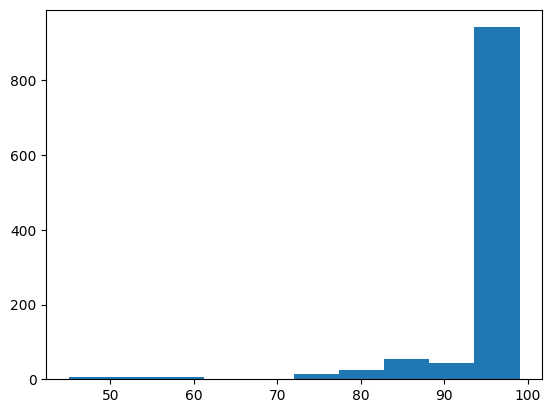

In [31]:
# analysis and validation of fuzzy search results
similarity_scores_village_master_list = pd.Series([v[1] for v in v_with_more_than_two_desc_term_but_no_match["fuzzy_search_result"]])
plt.hist(similarity_scores_village_master_list)
plt.show()

In [32]:
similarity_scores_village_master_list.describe()

count    1098.000000
mean       95.457195
std         7.002180
min        45.000000
25%        96.000000
50%        98.000000
75%        99.000000
max        99.000000
dtype: float64

#### Correcting wrongly inputted patient's origin with only one or two descriptive term
A fuzzy search is applied on the villages in the catchment area of the hf where the consultation was held.

In [33]:
# import list with correct villages descriptions of each hf
village_correction_by_hf_catchment_dict = pd.read_excel("data/rwanda/village/Village_correction_by_HF_catchment.xlsx", sheet_name=None) # NOTE file provided by domain experts
village_by_hf_catchment = pd.concat([v.assign(hf=k) for k, v in village_correction_by_hf_catchment_dict.items()], ignore_index=True)

# only keep villages in districts rusizi and nyamasheke as these are the only considered districts of the current study (according to domain expert)
village_by_hf_catchment = village_by_hf_catchment.loc[(village_by_hf_catchment["District"] == "Rusizi") | (village_by_hf_catchment["District"] == "Nyamasheke")]

In [34]:
# normalise hf column: remove underscore and numbers
village_by_hf_catchment["hf"] =  village_by_hf_catchment["hf"].str.replace(r"[\d_]", "")

In [35]:
# normalise: lower case (esepcially important for village, cell, sector, district)
village_by_hf_catchment = village_by_hf_catchment.applymap(lambda s: s.lower() if type(s) == str else s)

In [36]:
# create one string for the village description
# TODO: think about deleting since it has become obsolet. we match based on fuzzy search result on village value and not on willage_one_Word
village_by_hf_catchment["village_one_word"] = village_by_hf_catchment["Village"] + village_by_hf_catchment["Cell"] + village_by_hf_catchment["Sector"] + village_by_hf_catchment["District"]

In [37]:
# get consultations with wrongly inputted patient's origin since they only got one descriptive term
v_with_one_or_two_desc_term_and_no_match = v[( (v["count_desc_values"] == 1) | (v["count_desc_values"] == 2) ) & v["Village_Name"].isna()]
v_with_one_or_two_desc_term_and_no_match[['count_desc_values', 'village_one_word', 'Village_Name', 'Cell_Name', 'Sector_Name', 'District_Name']]

,count_desc_values,village_one_word,Village_Name,Cell_Name,Sector_Name,District_Name
33,1,nyamagana,NaN,NaN,NaN,NaN
36,1,kabumbwe,NaN,NaN,NaN,NaN
46,1,rwinkwavu,NaN,NaN,NaN,NaN
59,2,mubugaka,NaN,NaN,NaN,NaN
98,1,kabageni,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
47968,1,misave,NaN,NaN,NaN,NaN
47980,1,yove,NaN,NaN,NaN,NaN
47999,1,kankuba,NaN,NaN,NaN,NaN
48020,1,mpoga,NaN,NaN,NaN,NaN


In [38]:
# normalise column "health_facility_name": remove whitespaces, RW, CS and text in brackets as well as lowecase final textd
v_with_one_or_two_desc_term_and_no_match["health_facility_name"] = [hf.split(" ")[1].lower() for hf in v_with_one_or_two_desc_term_and_no_match["health_facility_name"]]

In [39]:
# perform fuzzy search to find proper village description from the list of villages that are 5km away from the hf
def fuzzy_search_in_catchment_area(village, hf):
    if not (hf in village_by_hf_catchment["hf"].unique()):
        return "hf not in list"
    villages_in_catchment_area = village_by_hf_catchment[village_by_hf_catchment["hf"] == hf]
    closeness_score = [fuzz.ratio(village, v) for v in villages_in_catchment_area[ "Village"]]
    max_value = max(closeness_score)
    max_index = closeness_score.index(max_value)
    best_match = villages_in_catchment_area.iloc[max_index].values
    return (max_index, max_value, best_match)

In [40]:
v_with_one_or_two_desc_term_and_no_match["fuzzy_search_result"] = v_with_one_or_two_desc_term_and_no_match.apply(lambda row: fuzzy_search_in_catchment_area(row.village_one_word, row.health_facility_name), axis=1)

In [41]:
# making out of fuzzy_search_result column multiple columns
v_with_one_or_two_desc_term_and_no_match[['index_best_match_in_ref_list', 'similarity_score', "best_match"]] = v_with_one_or_two_desc_term_and_no_match['fuzzy_search_result'].apply(lambda x: pd.Series(x))
v_with_one_or_two_desc_term_and_no_match[['best_match_village', 'best_match_cell', "best_match_sector", "best_match_district", "hf", "village_one_word"]] = v_with_one_or_two_desc_term_and_no_match['best_match'].apply(lambda x: pd.Series(x))

In [42]:
# remove consultations where patient's origin can not be found in the given hf catchment area
v_not_represented_in_hf_catchment_area_list = v_with_one_or_two_desc_term_and_no_match[~v_with_one_or_two_desc_term_and_no_match["similarity_score"].isna()]
v_not_represented_in_hf_catchment_area_list 

print(v_not_represented_in_hf_catchment_area_list.shape[0], "of", v_with_one_or_two_desc_term_and_no_match.shape[0],"consultations could not be found.")

618 of 634 consultations could not be found.


In [43]:
# viewing fuzzy search result 
# NOTE: the order of the best match of the fuzzy search result is Village, Cell, Sector, District	
v_with_one_or_two_desc_term_and_no_match[["BD9 - Village (Umudugudu) - 8062", "fuzzy_search_result"]]

,BD9 - Village (Umudugudu) - 8062,fuzzy_search_result
33,nyamagana,"(73, 100, [nyamagana, kabuye, nyakarenzo, rusi..."
36,kabumbwe,"(61, 100, [kabumbwe, gatare, nyakarenzo, rusiz..."
46,rwinkwavu,"(28, 100, [rwinkwavu, turambi, giheke, rusizi,..."
59,"mubuga,ka","(7, 86, [mubuga, kacyuma, gashonga, rusizi, mi..."
98,kabageni,"(94, 100, [kabageni, miko, mururu, rusizi, gih..."
...,...,...
47968,misave,"(18, 100, [misave, rusayo, gashonga, rusizi, m..."
47980,yove,"(7, 100, [yove, mutongo, cyato, nyamasheke, yo..."
47999,kankuba,"(46, 100, [kankuba, mashesha, gitambi, rusizi,..."
48020,mpoga,"(83, 100, [mpoga, kamanu, nyakabuye, rusizi, m..."


In [44]:
# analysis and validation of fuzzy search results
similarity_scores_hf_catchment_area_list = pd.Series([v[1] for v in v_with_one_or_two_desc_term_and_no_match["fuzzy_search_result"]])
similarity_scores_hf_catchment_area_list = similarity_scores_hf_catchment_area_list.replace("f", np.nan)

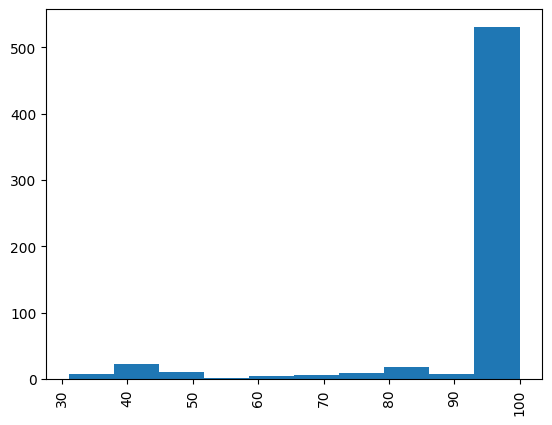

In [45]:
plt.hist(similarity_scores_hf_catchment_area_list)
plt.xticks(rotation=90)
plt.show()


In [46]:
similarity_scores_hf_catchment_area_list.describe()

count    618.000000
mean      94.449838
std       15.529495
min       31.000000
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000000
dtype: float64

In [47]:
# export fuzzy search results based on master list as excel for domain experts
villages_cleaned_by_master_list_fuzzy_search =  v_with_more_than_two_desc_term_but_no_match[["BD9 - Village (Umudugudu) - 8062", "fuzzy_search_result"]]
villages_cleaned_by_master_list_fuzzy_search[['index_master_list', 'similarity_score', "best_match"]] = villages_cleaned_by_master_list_fuzzy_search['fuzzy_search_result'].apply(lambda x: pd.Series(x))
villages_cleaned_by_master_list_fuzzy_search[['best_match_district', 'best_match_sector', "best_match_cell", "best_match_village", "village_one_word"]] = villages_cleaned_by_master_list_fuzzy_search['best_match'].apply(lambda x: pd.Series(x))
villages_cleaned_by_master_list_fuzzy_search[["original_version_village", "original_version_cell", 'original_version_sector', 'original_version_district', "original_version_wrong_fifth_description_term"]] = villages_cleaned_by_master_list_fuzzy_search["BD9 - Village (Umudugudu) - 8062"].str.split(',', expand=True)
villages_cleaned_by_master_list_fuzzy_search["village_name_original_version_matches_catchment_area_list"] = villages_cleaned_by_master_list_fuzzy_search["original_version_village"] == villages_cleaned_by_master_list_fuzzy_search["best_match_village"]
villages_cleaned_by_master_list_fuzzy_search[["original_version_district", "original_version_sector", 'original_version_cell', 'original_version_village', "original_version_wrong_fifth_description_term", 'best_match_district', 'best_match_sector', "best_match_cell", "best_match_village", "similarity_score", "village_name_original_version_matches_catchment_area_list"]].to_excel("data/rwanda/cleaning-villages-results/villages_cleaned_by_master_list_fuzzy_search.xlsx")

In [48]:
# export fuzzy search results based on catchment area list as excel for domain experts
villages_cleaned_by_hf_catchment_area_fuzzy_search =  v_with_one_or_two_desc_term_and_no_match[["BD9 - Village (Umudugudu) - 8062", "fuzzy_search_result"]]
villages_cleaned_by_hf_catchment_area_fuzzy_search[['index_catchment_area_list', 'similarity_score', "best_match"]] = villages_cleaned_by_hf_catchment_area_fuzzy_search['fuzzy_search_result'].apply(lambda x: pd.Series(x))
villages_cleaned_by_hf_catchment_area_fuzzy_search[['best_match_village', 'best_match_cell', "best_match_sector", "best_match_district", "hf", "village_one_word"]] = villages_cleaned_by_hf_catchment_area_fuzzy_search['best_match'].apply(lambda x: pd.Series(x))
villages_cleaned_by_hf_catchment_area_fuzzy_search["original_version_village"] = villages_cleaned_by_hf_catchment_area_fuzzy_search["BD9 - Village (Umudugudu) - 8062"]
villages_cleaned_by_hf_catchment_area_fuzzy_search["village_name_original_version_matches_catchment_area_list"] = villages_cleaned_by_hf_catchment_area_fuzzy_search["original_version_village"] == villages_cleaned_by_hf_catchment_area_fuzzy_search["best_match_village"]
villages_cleaned_by_hf_catchment_area_fuzzy_search[['original_version_village', 'best_match_district', 'best_match_sector', "best_match_cell", "best_match_village", "similarity_score", "village_name_original_version_matches_catchment_area_list"]].to_excel("data/rwanda/cleaning-villages-results/villages_cleaned_by_hf_catchment_area_fuzzy_search.xlsx")

In [49]:
# validate fuzzy search results based on hf catchment area list
print(sum(villages_cleaned_by_hf_catchment_area_fuzzy_search["village_name_original_version_matches_catchment_area_list"]), "fuzzy search results with the hf catchment area list have a matching village name value. This is", sum(villages_cleaned_by_hf_catchment_area_fuzzy_search["village_name_original_version_matches_catchment_area_list"])/villages_cleaned_by_hf_catchment_area_fuzzy_search["village_name_original_version_matches_catchment_area_list"].shape[0]*100,"%","of all results.")

525 fuzzy search results with the hf catchment area list have a matching village name value. This is 82.80757097791798 % of all results.


In [50]:
# to verify that some inputted villages have empty rows in df: village_by_hf_catchment (the reason is that their hf is not in the hf_catchment_area_list)
print(village_by_hf_catchment[village_by_hf_catchment["Village"] == "kivog"] )
v_with_one_or_two_desc_term_and_no_match.loc[v_with_one_or_two_desc_term_and_no_match["BD9 - Village (Umudugudu) - 8062"]== "kivog", ["BD9 - Village (Umudugudu) - 8062", "health_facility_name", "fuzzy_search_result"]]

Empty DataFrame
Columns: [Village, Cell, Sector, District, hf, village_one_word]
Index: []


,BD9 - Village (Umudugudu) - 8062,health_facility_name,fuzzy_search_result
1959,kivog,mont,hf not in list


#### Constructing the final data set with cleaned patient's origin column

In [51]:
v_with_correct_village_desc["fuzzy_search_result"] = np.nan
rw_data_with_cleaned_village = pd.concat([v_with_correct_village_desc, v_with_one_or_two_desc_term_and_no_match, v_with_more_than_two_desc_term_but_no_match])

#### Drop consultations with bad fuzzy search results
Due to consent of domain experts, consultations with bad fuzzy search results will be dropped based on an arbitrarily chosen similarity score threshold that can easily be adjusted.

In [52]:
similarity_score_threshold = 90
cleaned_rw_data = rw_data_with_cleaned_village[
    (rw_data_with_cleaned_village['similarity_score'] >= similarity_score_threshold) | 
    (rw_data_with_cleaned_village['similarity_score'].isna() & rw_data_with_cleaned_village['fuzzy_search_result'].isna()) # includes consultations whose patient's origin was immediately found in village master list due to join
]

print(rw_data_with_cleaned_village.shape[0]-cleaned_rw_data.shape[0], 
    "consultations were dropped using a similarity score threshold of", 
    similarity_score_threshold
)
print("This accounts for", 
    (rw_data_with_cleaned_village.shape[0]-cleaned_rw_data.shape[0])/rw_data_with_cleaned_village.shape[0]*100, 
    "%", 
    "of all consultations"
)

221 consultations were dropped using a similarity score threshold of 90
This accounts for 0.45939260398694576 % of all consultations


# Data preparation

### Adding another spatial dimension: the patient's origin

In [64]:
# import shapes of all villages in RW
import shapefile

shape_meta = shapefile.Reader("data/rwanda/village/shapefiles/Village.dbf")
shapeRec = pd.DataFrame(shape_meta.shapeRecords().__geo_interface__["features"])

# extracting the relevant columns
shapeRec[['District', 'Sector', 'Cell', "Village"]] = shapeRec['properties'].apply(lambda x: pd.Series([x['District'], x['Sector'],x['Cell'], x['Name']]))
shapeRec["coordinates"] = shapeRec["geometry"].apply(lambda x: pd.Series([x["coordinates"]]))
rw_village_coordinates = shapeRec[['District', 'Sector', 'Cell', "Village", "coordinates"]]
rw_village_coordinates

,District,Sector,Cell,Village,coordinates
0,Nyarugenge,Gitega,Akabahizi,Gihanga,"[[(505804.1074000001, 4784697.3946), (505808.8..."
1,Nyarugenge,Gitega,Akabahizi,Iterambere,"[[(505725.3504999997, 4785070.964), (505750.76..."
2,Nyarugenge,Gitega,Akabahizi,Izuba,"[[(505689.33939999994, 4785047.2246), (505712...."
3,Nyarugenge,Gitega,Akabahizi,Nyaburanga,"[[(506082.3940000003, 4784751.6763), (506066.2..."
4,Nyarugenge,Gitega,Akabahizi,Nyenyeri,"[[(505779.44519999996, 4784753.8181), (505787...."
...,...,...,...,...,...
14810,Bugesera,Shyara,Rutare,Gaseke,"[[(500470.19570000004, 4749405.5013999995), (5..."
14811,Bugesera,Shyara,Rutare,Kamweru,"[[(499906.30709999986, 4747938.3901), (499914...."
14812,Bugesera,Shyara,Rutare,Ruhanga,"[[(498708.4414999997, 4748230.242699999), (498..."
14813,Bugesera,Shyara,Rutare,Rutare,"[[(500611.2845999999, 4748742.6085), (500635.3..."


In [65]:
# normalise string columns (lowercase) and create one word of the village description
rw_village_coordinates = rw_village_coordinates.applymap(lambda s: s.lower() if type(s) == str else s)
rw_village_coordinates

,District,Sector,Cell,Village,coordinates
0,nyarugenge,gitega,akabahizi,gihanga,"[[(505804.1074000001, 4784697.3946), (505808.8..."
1,nyarugenge,gitega,akabahizi,iterambere,"[[(505725.3504999997, 4785070.964), (505750.76..."
2,nyarugenge,gitega,akabahizi,izuba,"[[(505689.33939999994, 4785047.2246), (505712...."
3,nyarugenge,gitega,akabahizi,nyaburanga,"[[(506082.3940000003, 4784751.6763), (506066.2..."
4,nyarugenge,gitega,akabahizi,nyenyeri,"[[(505779.44519999996, 4784753.8181), (505787...."
...,...,...,...,...,...
14810,bugesera,shyara,rutare,gaseke,"[[(500470.19570000004, 4749405.5013999995), (5..."
14811,bugesera,shyara,rutare,kamweru,"[[(499906.30709999986, 4747938.3901), (499914...."
14812,bugesera,shyara,rutare,ruhanga,"[[(498708.4414999997, 4748230.242699999), (498..."
14813,bugesera,shyara,rutare,rutare,"[[(500611.2845999999, 4748742.6085), (500635.3..."


In [70]:
# add coordinates to final df
# NOTE: merging the "rw_village_coordinates" needs to be 
# differentiated for consultations whose patient's origin 
# was correctly inputted and not. Both requires different join keys
prepared_cleaned_rw_data = pd.concat([
    cleaned_rw_data.merge(
        rw_village_coordinates, 
        left_on=['District_Name', 'Sector_Name', 'Cell_Name', 'Village_Name'], 
        right_on=['District', 'Sector', 'Cell', 'Village']
    ),
    cleaned_rw_data.merge(rw_village_coordinates, 
        left_on=['best_match_district', 'best_match_sector', 'best_match_cell', 'best_match_village'], 
        right_on=['District', 'Sector', 'Cell', 'Village']
    )
])

## suggested data preparation

In [71]:
# add "medical_case_consultation_date_day" column which gives just the data of the consultation day (no time)
prepared_cleaned_rw_data["medical_case_consultation_date_day"] = prepared_cleaned_rw_data["medical_case_consultation_date"].str.slice(0,10)

In [72]:
# add "patient_age" column which gives the age of the patient at the time of consultation in years instead of days like in patient_birthdate
prepared_cleaned_rw_data["patient_age"] = (prepared_cleaned_rw_data["patient_birthdate"] / 365) // 1

# Storing cleaned and prepared consultation data from RW

In [73]:
prepared_cleaned_rw_data.to_pickle("data/rw-cleaned-prepared-dynamic-data-phase1.pickle")

In [75]:
rw_village_coordinates.to_pickle("data/rw-village-coordinates.pickle")

# Conclusion
In the course of this notebook's cleaning and preparing of CDSS data from RW, the following actions led to droping consultations:

- during the import, 1 consultation (= line 9087 of the raw data) was dropped since it was wrongly formated so that the import recognised more columns in this row as usual. 
- TODO